# PCA analysis
Author: Lujun [github](https://github.com/DobricLilujun/temperature_eval)

This notebook is dedicated to conducting Principal Component Analysis (PCA) on creativity ability in order to examine the generative space along the two principal components.

Data Gathering

In [1]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt

current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

folder_path = "Paper Experiment Results/New_filtered/creativity"
output_photo_name = f"CT_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["weight_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)


def label_function(x):
    if str(x).startswith("Yes"):
        return True
    elif str(x).startswith("No"):
        return False
    else:
        return None


df["label"] = df["OpenAI_response"].apply(label_function)
df = df[~df["label"].isna()]
df = df[df["Temperature"] != "temperature"]
df["Temperature"] = df["Temperature"].astype(float).round(1)
df.drop_duplicates(subset=["pure_response"], keep="first", inplace=True)

Use gpt2 embeddings and do PCA for each temperature of dataset

In [ ]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from transformers import BertModel, BertTokenizer
from transformers import GPT2Tokenizer, GPT2Model
import torch

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")


def get_paragraph_embedding(paragraph):
    inputs = tokenizer(paragraph, return_tensors="pt", max_length=1024, truncation=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].detach().numpy()


temperatures = df["Temperature"].tolist()
grouped_responses = {}
for index, row in df.iterrows():
    temp = row["Temperature"]
    if row["Temperature"] not in grouped_responses:
        grouped_responses[temp] = []
    grouped_responses[temp].append(index)

plt.figure(figsize=(40, 6))
reduced_embeddings_list = []
fig, axs = plt.subplots(1, 7, figsize=(40, 6))

for i, (temp, indices) in enumerate(grouped_responses.items()):
    group_responses = df.loc[indices, "pure_response"].tolist()
    embeddings = np.vstack(
        [get_paragraph_embedding(response) for response in group_responses]
    )
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    reduced_embeddings_list.append(reduced_embeddings)
    axs[i].scatter(
        reduced_embeddings[:, 0], reduced_embeddings[:, 1], label=f"Temperature: {temp}"
    )
    axs[i].set_xlabel("Principal Component 1")
    axs[i].set_ylabel("Principal Component 2")
    axs[i].set_title(f"PCA of Pure Responses Grouped by Temperature {temp}")
    axs[i].legend()

plt.tight_layout()
plt.show()

Put everything together and do PCA on all the embedding at one time

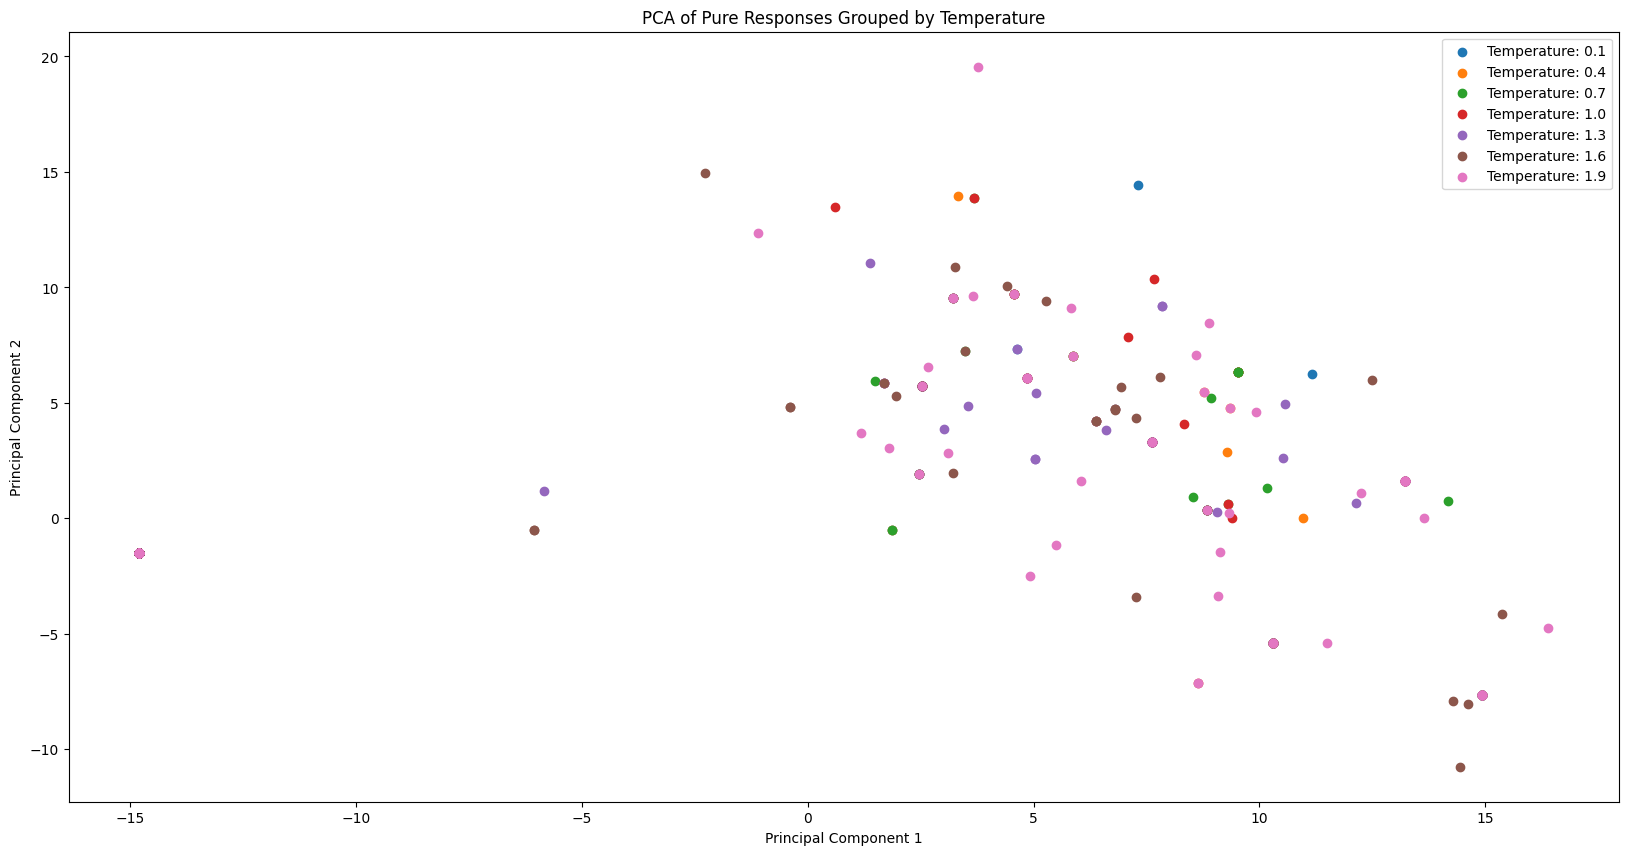

In [21]:
embeddings = np.vstack(
    [get_paragraph_embedding(response) for response in df["pure_response"].tolist()]
)

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

df["PCA1"] = reduced_embeddings[:, 0]
df["PCA2"] = reduced_embeddings[:, 1]

Set x lim and y lim for resizing and visualize the PCA component in different temperature

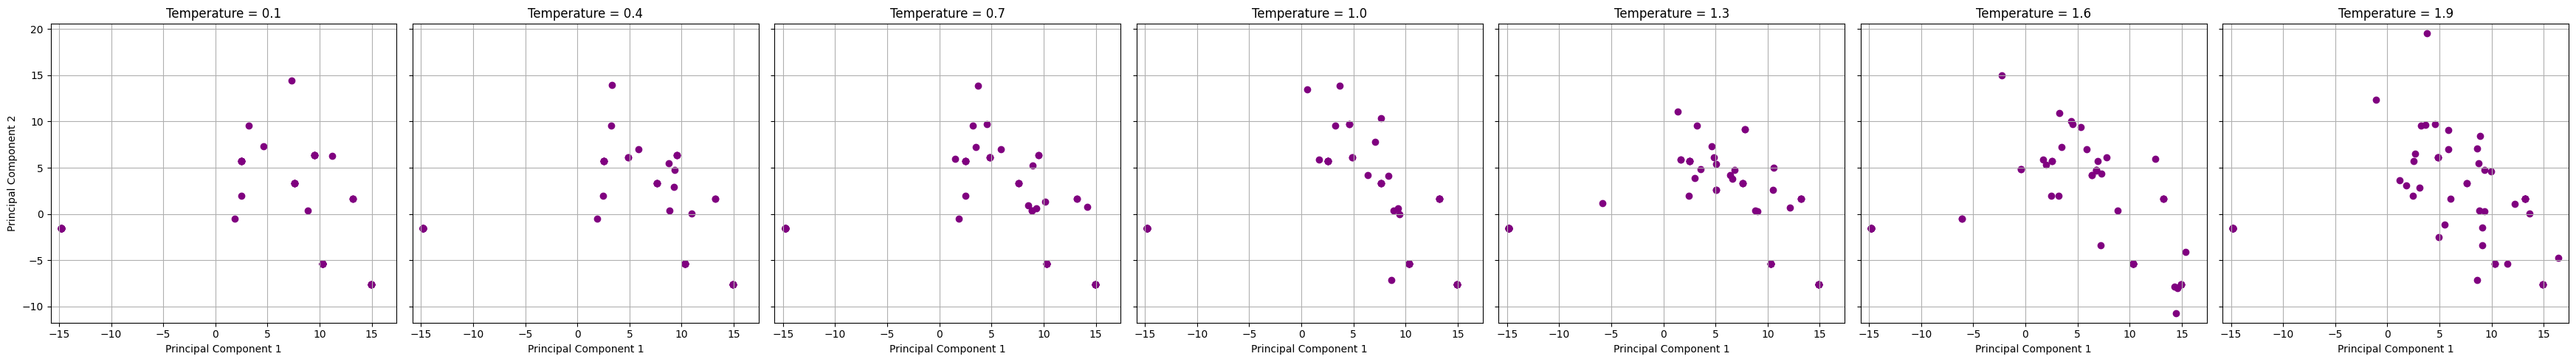

In [35]:
temperatures = df["Temperature"].unique()
fig, axs = plt.subplots(1, len(temperatures), figsize=(5 * len(temperatures), 5))
x_min, x_max = df["PCA1"].min() - 1, df["PCA1"].max() + 1
y_min, y_max = df["PCA2"].min() - 1, df["PCA2"].max() + 1

for i, temp in enumerate(temperatures):
    temp_df = df[df["Temperature"] == temp]
    axs[i].scatter(
        temp_df["PCA1"], temp_df["PCA2"], label=f"Temperature: {temp}", color="purple"
    )
    axs[i].set_xlabel("Principal Component 1")
    if i == 0:
        axs[i].set_ylabel("Principal Component 2")
    else:
        axs[i].tick_params(
            labelleft=False
        )
    axs[i].set_title(f"Temperature = {temp}")
    axs[i].set_xlim(x_min, x_max)
    axs[i].set_ylim(y_min, y_max)
    axs[i].grid(True)

plt.tight_layout()
plt.savefig("PCA.svg", format="svg")
plt.show()

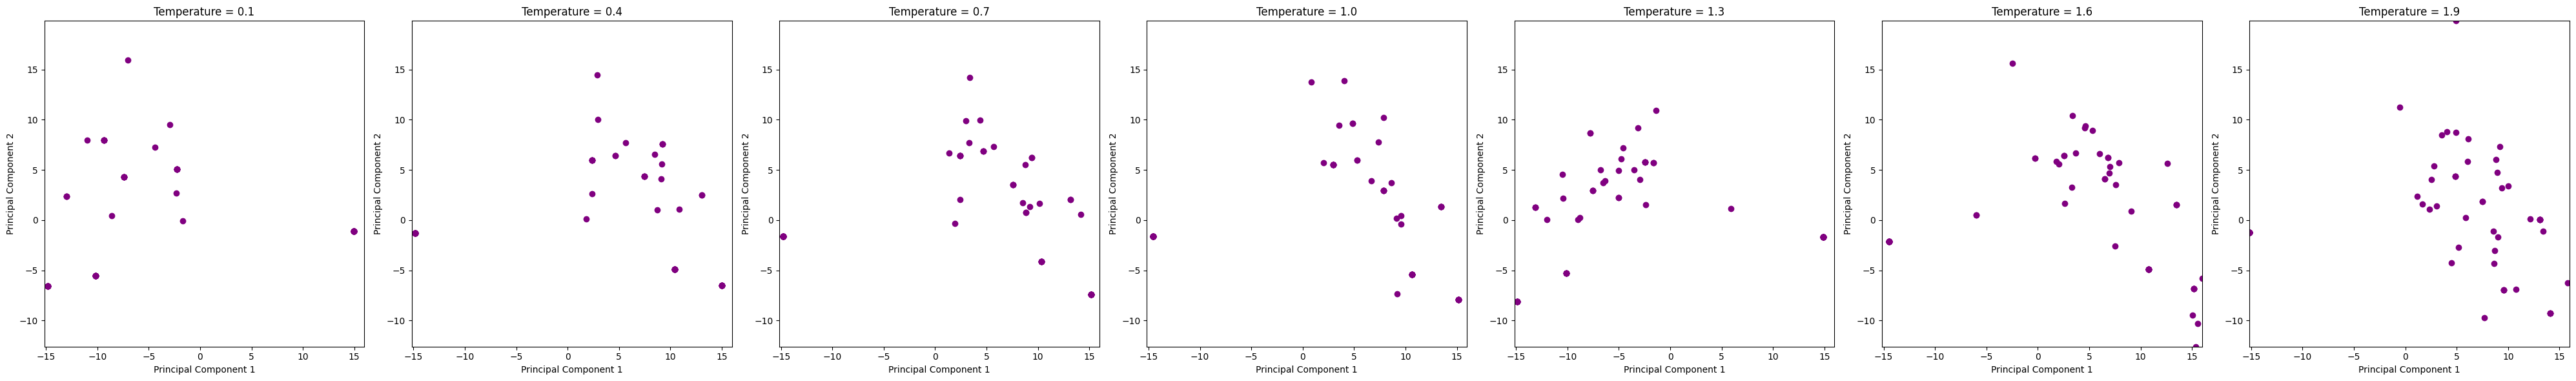

In [20]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 7, figsize=(40, 6))
all_embeddings = np.vstack(reduced_embeddings_list)
temperatures = [0.1, 0.4, 0.7, 1.0, 1.3, 1.6, 1.9]
x_min, x_max = all_embeddings[:, 0].min(), all_embeddings[:, 0].max()
y_min, y_max = all_embeddings[:, 1].min(), all_embeddings[:, 1].max()

for i, embeddings in enumerate(reduced_embeddings_list):
    scatter = axs[i].scatter(
        embeddings[:, 0],
        embeddings[:, 1],
        label=f"Temperature: {temperatures[i]}",
        color="purple",
    )
    axs[i].set_xlabel("Principal Component 1")
    axs[i].set_ylabel("Principal Component 2")
    axs[i].set_title(f"Temperature = {temperatures[i]}")
    axs[i].set_xlim(x_min, x_max)
    axs[i].set_ylim(y_min, y_max)

plt.tight_layout()

plt.show()